In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import json
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import matplotlib.pyplot as plt

In [2]:
# Metal GPU support
if torch.backends.mps.is_available():
    device = torch.device("mps")  # "mps" stands for Metal Performance Shaders (Apple's Metal API)
    print("Using Apple Metal GPU.")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU.")

Using Apple Metal GPU.


Dataset

In [3]:
# chord name to index mapping
chord_to_int = {'A#:maj': 0, 'A:maj': 1, 'A:min': 2, 'Ab:maj': 3, 'Ab:min': 4, 'B:maj': 5, 'B:min': 6, 'Bb:maj': 7, 'Bb:min': 8, 'C#:maj': 9, 'C#:min': 10, 'C:maj': 11, 'C:min': 12, 'Cb:maj': 13, 'D#:maj': 14, 'D#:min': 15, 'D:maj': 16, 'D:min': 17, 'Db:maj': 18, 'Db:min': 19, 'E:maj': 20, 'E:min': 21, 'Eb:maj': 22, 'Eb:min': 23, 'F#:maj': 24, 'F#:min': 25, 'F:maj': 26, 'F:min': 27, 'Fb:maj': 28, 'G#:maj': 29, 'G#:min': 30, 'G:maj': 31, 'G:min': 32, 'Gb:maj': 33, 'Gb:min': 34, 'N': 35, 'X': 36}

int_to_chord = {0: 'A#:maj', 1: 'A:maj', 2: 'A:min', 3: 'Ab:maj', 4: 'Ab:min', 5: 'B:maj', 6: 'B:min', 7: 'Bb:maj', 8: 'Bb:min', 9: 'C#:maj', 10: 'C#:min', 11: 'C:maj', 12: 'C:min', 13: 'Cb:maj', 14: 'D#:maj', 15: 'D#:min', 16: 'D:maj', 17: 'D:min', 18: 'Db:maj', 19: 'Db:min', 20: 'E:maj', 21: 'E:min', 22: 'Eb:maj', 23: 'Eb:min', 24: 'F#:maj', 25: 'F#:min', 26: 'F:maj', 27: 'F:min', 28: 'Fb:maj', 29: 'G#:maj', 30: 'G#:min', 31: 'G:maj', 32: 'G:min', 33: 'Gb:maj', 34: 'Gb:min', 35: 'N', 36: 'X'}

In [4]:
import os

def get_csv_file_paths(directory_path):
    """
    Given a directory path, go through each CSV file in the directory,
    append their paths into a list, and return the list.

    Args:
        directory_path (str): Path to the directory containing CSV files.

    Returns:
        list: List of file paths to all CSV files in the directory.
    """
    csv_file_paths = []
    
    # Check if the provided path is valid
    if not os.path.isdir(directory_path):
        raise ValueError(f"The provided path '{directory_path}' is not a valid directory.")
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        # Check if the file has a .csv extension
        if filename.endswith(".csv"):
            # Append the full path to the list
            full_path = os.path.join(directory_path, filename)
            csv_file_paths.append(full_path)
    
    return csv_file_paths

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from collections import Counter

class AudioChordDataset(Dataset):
    def __init__(self, csv_dir, csv_file_names, N, chord_to_int):
        """
        Args:
            csv_file_paths (list of str): List of paths to CSV files.
            N (int): Number of timestamps in each block (sliding window size).
        """
        self.csv_file_names = csv_file_names
        self.N = N
        self.data = []
        self.labels = []
        self.chord_to_int = chord_to_int

        # Load and process each CSV file
        for file_name in self.csv_file_names:
            file_path = os.path.join(csv_dir, file_name)
            df = pd.read_csv(file_path)
            # Get frequency domain values and labels as numpy arrays
            freq_data = df.iloc[:, 1:25].values  # Select the 25 frequency columns
            labels = df.iloc[:, 25].values  # Select the label column
            
            # Append data blocks and labels using a sliding window approach
            for i in range(len(freq_data) - N + 1):
                block = freq_data[i:i + N]  # N x 26
                block_labels = labels[i:i + N]  # Labels in the block

                # Find the most common label in the block
                most_common_label = Counter(block_labels).most_common(1)[0][0]
                
                # Map chord name to integer
                numeric_label = self.chord_to_int.get(most_common_label, self.chord_to_int["X"]) # Default to "X" if unknown
                
                self.data.append(block)
                self.labels.append(numeric_label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        block = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)  # Shape: N x 26
        label = torch.tensor(self.labels[idx])  # This is still a string (chord name)
        return block, label

In [6]:
def read_list_from_json(file_path):
    """
    Reads a JSON file and returns the original Python list.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        list: List read from the JSON file.

    Raises:
        ValueError: If the JSON file content is not a list.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    
    if not isinstance(data, list):
        raise ValueError("The content of the JSON file is not a list.")
    
    return data

In [7]:
train_csv_file_names = read_list_from_json(os.path.join("train_test_split", "train_csv_paths.json"))
val_csv_file_names = read_list_from_json(os.path.join("train_test_split", "val_csv_paths.json"))
test_csv_file_names = read_list_from_json(os.path.join("train_test_split", "test_csv_paths.json"))

csv_dir = "processed_data"

Model

In [8]:
class CNN_Model(nn.Module):
    def __init__(self, window_size, num_classes):
        super(CNN_Model, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=1, padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2, ceil_mode=True)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2,  ceil_mode=True)
        )
        # Dynamically compute the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, window_size, 24)  # Example input size (batch_size=1, channels=1, window_size, num_features)
            output = self.layer2(self.layer1(dummy_input))
            self.flattened_size = output.numel()
            
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # out.size(0) gives the batch size. output will become (batch_size, flattened_size)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Learning rate finder

/Users/allynbao/miniconda3/envs/music_transcription/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


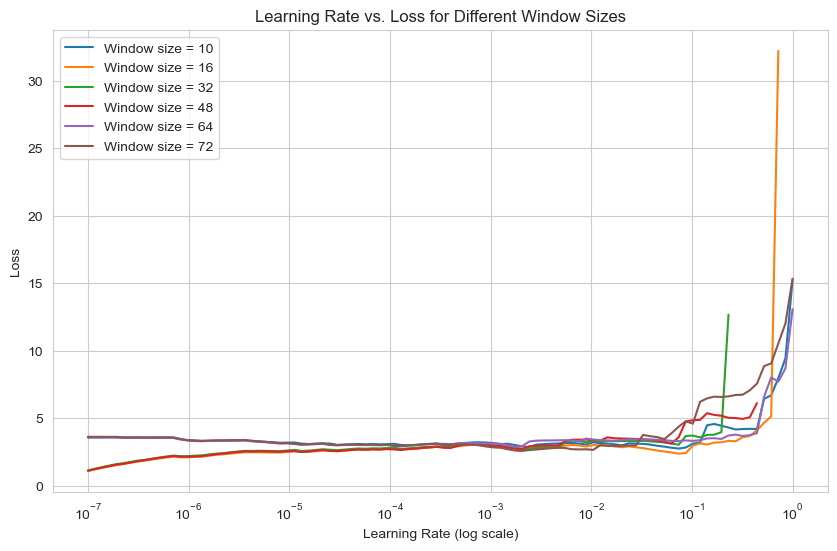

In [9]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# Store the data for plotting
lr_curves = {}

window_sizes = [10, 16, 32, 48, 64, 72]
batch_size = 128
num_classes = 36

for win_size in window_sizes:
    step_size = win_size // 2  # Half overlapping windows

    # Load datasets
    train_dataset = AudioChordDataset(csv_dir, train_csv_file_names, win_size, chord_to_int)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and criterion
    model = CNN_Model(window_size=win_size, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
    criterion = torch.nn.CrossEntropyLoss()

    # Perform learning rate range test
    lr_finder = LRFinder(model, optimizer, criterion, device="mps")
    lr_finder.range_test(train_dataloader, end_lr=1, num_iter=100)
    
    # Store learning rate and loss data
    lr_curves[win_size] = (lr_finder.history["lr"], lr_finder.history["loss"])

# Plot all curves
plt.figure(figsize=(10, 6))
for win_size, (lrs, losses) in lr_curves.items():
    plt.plot(lrs, losses, label=f"Window size = {win_size}")

plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Loss")
plt.title("Learning Rate vs. Loss for Different Window Sizes")
plt.legend()
plt.grid(True)
plt.show()

Conclusion: Learning rate range 10e-3, 10e-1, region of decreasing loss, the loss rapidly increases beyond 10e-1, indicating divergence. 

From this graph, the best performing window size seems to be 48, 64, 72, although all window_size output similar loss. 

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


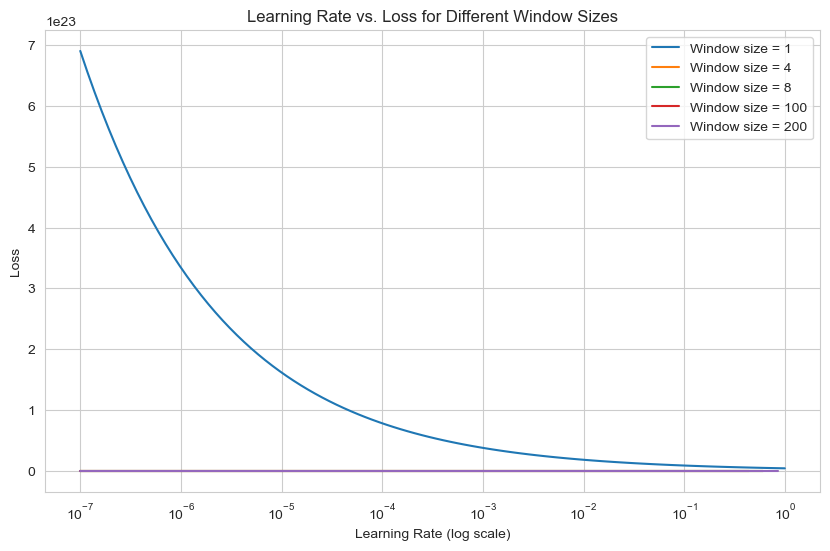

In [10]:
import matplotlib.pyplot as plt

# Store the data for plotting
lr_curves = {}

window_sizes = [1, 4, 8, 100, 200]
batch_size = 128
num_classes = 36

for win_size in window_sizes:
    step_size = win_size // 2  # Half overlapping windows

    # Load datasets
    train_dataset = AudioChordDataset(csv_dir, train_csv_file_names, win_size, chord_to_int)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and criterion
    model = CNN_Model(window_size=win_size, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
    criterion = torch.nn.CrossEntropyLoss()

    # Perform learning rate range test
    lr_finder = LRFinder(model, optimizer, criterion, device="mps")
    lr_finder.range_test(train_dataloader, end_lr=1, num_iter=100)
    
    # Store learning rate and loss data
    lr_curves[win_size] = (lr_finder.history["lr"], lr_finder.history["loss"])

# Plot all curves
plt.figure(figsize=(10, 6))
for win_size, (lrs, losses) in lr_curves.items():
    plt.plot(lrs, losses, label=f"Window size = {win_size}")

plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Loss")
plt.title("Learning Rate vs. Loss for Different Window Sizes")
plt.legend()
plt.grid(True)
plt.show()

Training Loop

Epoch 1/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.614814631163087; val accuracy=59.96682714471064%


Epoch 2/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5546520980287337; val accuracy=61.84931539401082%


Epoch 3/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.576614332176897; val accuracy=61.319246751230516%


Epoch 4/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6190830277461596; val accuracy=61.09587652220474%


Epoch 5/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.643435313336627; val accuracy=60.43828090469695%


Epoch 6/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6383085904346948; val accuracy=60.09023523578232%


Epoch 7/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.678382903833104; val accuracy=59.966668726108495%


Epoch 8/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6216233740687427; val accuracy=60.29839727900209%


Epoch 9/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5667952291173333; val accuracy=63.86440001330716%


Epoch 10/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5661851045062716; val accuracy=63.85473647857626%


Epoch 11/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5707694596318695; val accuracy=63.775368758901145%


Epoch 12/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5801750753367683; val accuracy=63.6952089462153%


Epoch 13/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5867468613451858; val accuracy=63.68095127202216%


Epoch 14/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5939403485933947; val accuracy=63.68285229524792%


Epoch 15/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.569635189452441; val accuracy=64.12864224168659%


Epoch 16/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5703855575339345; val accuracy=64.12785014867586%


Epoch 17/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5712677650308151; val accuracy=64.12848382308444%


Epoch 18/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5720977890738204; val accuracy=64.1400483810411%


Epoch 19/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5727549611581744; val accuracy=64.13371163695525%


Epoch 20/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5734939897978815; val accuracy=64.13482056717028%
0


Epoch 1/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.516719509316131; val accuracy=62.33534366539457%


Epoch 2/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5309829486692728; val accuracy=62.15332069152888%


Epoch 3/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5386931720334829; val accuracy=62.42564226861775%


Epoch 4/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.576862571551985; val accuracy=61.81636432476447%


Epoch 5/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5697564733644587; val accuracy=62.32520487485723%


Epoch 6/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6040902033774567; val accuracy=63.004187003654714%


Epoch 7/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6073719592542346; val accuracy=62.516574546249515%


Epoch 8/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.575465018573103; val accuracy=64.03644261523765%


Epoch 9/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5827754438460422; val accuracy=64.00713517384065%


Epoch 10/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5897285816251072; val accuracy=64.00016475534623%


Epoch 11/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.594873290647424; val accuracy=63.99541219728185%


Epoch 12/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6004320252871582; val accuracy=64.03786838265697%


Epoch 13/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6087084892324583; val accuracy=64.08919600975224%


Epoch 14/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6070807872359967; val accuracy=64.21688140308187%


Epoch 15/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6090344928006526; val accuracy=64.22892121684497%


Epoch 16/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6106398018103831; val accuracy=64.24919879791965%


Epoch 17/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6121251999818313; val accuracy=64.25125823974754%


Epoch 18/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6135091262011718; val accuracy=64.25379293738187%


Epoch 19/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6149647081598468; val accuracy=64.25632763501622%


Epoch 20/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6097625946595249; val accuracy=64.23003014705999%
1


Epoch 1/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.484688053929777; val accuracy=62.61827928882721%


Epoch 2/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.4936712038360844; val accuracy=62.11244869217523%


Epoch 3/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5194610393405812; val accuracy=61.587924700470026%


Epoch 4/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5440196648399; val accuracy=61.33493019284296%


Epoch 5/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5574837990004404; val accuracy=60.98910238435838%


Epoch 6/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.552910558826901; val accuracy=61.93391092755676%


Epoch 7/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.577379533677327; val accuracy=61.03868740683006%


Epoch 8/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5536091981606288; val accuracy=63.82717164180287%


Epoch 9/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5573551423742709; val accuracy=63.775368758901145%


Epoch 10/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5568450280491366; val accuracy=63.800715735244495%


Epoch 11/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5625772049810487; val accuracy=63.80134940965308%


Epoch 12/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5657032404352405; val accuracy=63.824161688362096%


Epoch 13/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.570075507638956; val accuracy=63.88673703620974%


Epoch 14/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5705574696495896; val accuracy=64.00634308082992%


Epoch 15/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5714945666956366; val accuracy=64.00761042964709%


Epoch 16/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.572331530566448; val accuracy=64.00776884824924%


Epoch 17/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5731837132522213; val accuracy=64.00428363900203%


Epoch 18/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5740636841913644; val accuracy=64.00364996459344%


Epoch 19/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5750068080131387; val accuracy=64.00602624362563%


Epoch 20/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5729896412208544; val accuracy=63.94630243061661%
2


Epoch 1/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5611809396064582; val accuracy=60.798841643181106%


Epoch 2/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5530017820703361; val accuracy=62.21415343475292%


Epoch 3/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.576767956534047; val accuracy=61.856761068311684%


Epoch 4/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5908826130858125; val accuracy=62.28227343367568%


Epoch 5/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5859781111703204; val accuracy=63.010048491934114%


Epoch 6/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5756883019275232; val accuracy=63.11872365300623%


Epoch 7/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5713048337029247; val accuracy=63.030326073008794%


Epoch 8/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5957414165330057; val accuracy=62.996424492149565%


Epoch 9/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5715829328480548; val accuracy=63.83984512997454%


Epoch 10/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5744037228524284; val accuracy=63.880083454919614%


Epoch 11/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5781049436149064; val accuracy=63.90669778008013%


Epoch 12/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5808616069604944; val accuracy=63.909707733520904%


Epoch 13/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5835351219516802; val accuracy=63.977352476637215%


Epoch 14/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5861846751651894; val accuracy=64.02091759222735%


Epoch 15/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.565842980480397; val accuracy=63.987966522981%


Epoch 16/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5672388992925295; val accuracy=63.99018438341104%


Epoch 17/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.568308166041945; val accuracy=63.986540755561684%


Epoch 18/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5693964069756372; val accuracy=63.9817881974973%


Epoch 19/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5699719938558645; val accuracy=63.99224382523894%


Epoch 20/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5708114264754802; val accuracy=63.99858056932477%
3


Epoch 1/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6369329149696934; val accuracy=58.848867069366754%


Epoch 2/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.591084326930638; val accuracy=59.58868194138829%


Epoch 3/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6190690046009; val accuracy=59.267725853440616%


Epoch 4/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6274013261933828; val accuracy=59.906628075895185%


Epoch 5/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.626475088191914; val accuracy=60.19510835040294%


Epoch 6/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6318513253785056; val accuracy=60.03558081804198%


Epoch 7/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.6346606179741026; val accuracy=60.0091249114836%


Epoch 8/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.635629290762106; val accuracy=60.341011882979345%


Epoch 9/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5769633721269003; val accuracy=62.65027984646069%


Epoch 10/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5741338182629698; val accuracy=62.698914357319495%


Epoch 11/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.570259534159071; val accuracy=62.86018449430406%


Epoch 12/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5678605946700441; val accuracy=62.989770910859434%


Epoch 13/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5688292004920115; val accuracy=62.940661144194195%


Epoch 14/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.565782066979281; val accuracy=63.18019007063886%


Epoch 15/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5687966037861771; val accuracy=63.22914141870195%


Epoch 16/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5722014995866984; val accuracy=63.28205323181869%


Epoch 17/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5776068431027104; val accuracy=63.27745909235646%


Epoch 18/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.5840593683770043; val accuracy=63.27666699934573%


Epoch 19/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.592421129598246; val accuracy=63.25512206945388%


Epoch 20/20:   0%|          | 0/9025 [00:00<?, ?batch/s]

val loss=1.601301241690527; val accuracy=63.21393323289594%
4
{0: {'train_losses': [1.3336207929476476, 1.1085748948664547, 1.0186744670045673, 0.9618541017017866, 0.9236438925035938, 0.8969884491536426, 0.8801129306392574, 0.8637547474779663, 0.7536586554566207, 0.7219944615014042, 0.7076388235198247, 0.6959577731753073, 0.6849299738970985, 0.6736794769148913, 0.6537168793155298, 0.6499724018485015, 0.647869347780943, 0.6460754661274418, 0.6444222262509972, 0.642830927193041], 'val_losses': [1.614814631163087, 1.5546520980287337, 1.576614332176897, 1.6190830277461596, 1.643435313336627, 1.6383085904346948, 1.678382903833104, 1.6216233740687427, 1.5667952291173333, 1.5661851045062716, 1.5707694596318695, 1.5801750753367683, 1.5867468613451858, 1.5939403485933947, 1.569635189452441, 1.5703855575339345, 1.5712677650308151, 1.5720977890738204, 1.5727549611581744, 1.5734939897978815], 'val_accuracies': [59.96682714471064, 61.84931539401082, 61.319246751230516, 61.09587652220474, 60.4382809

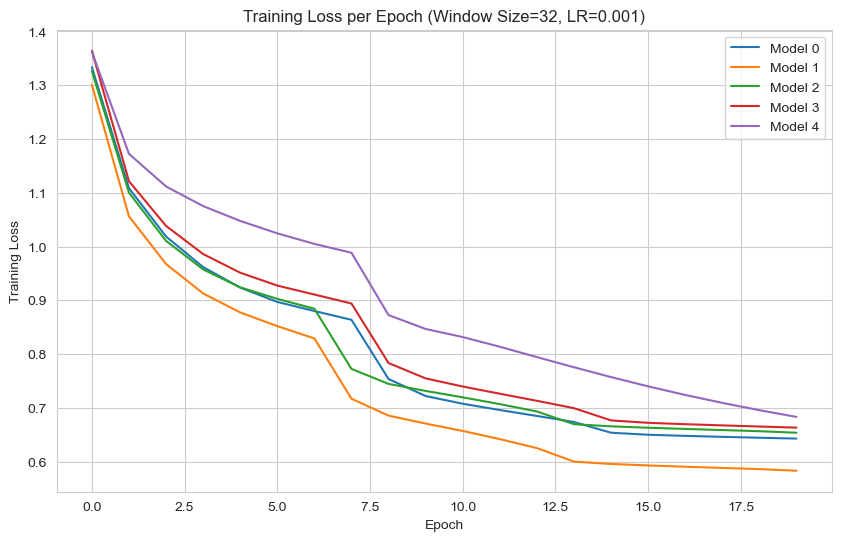

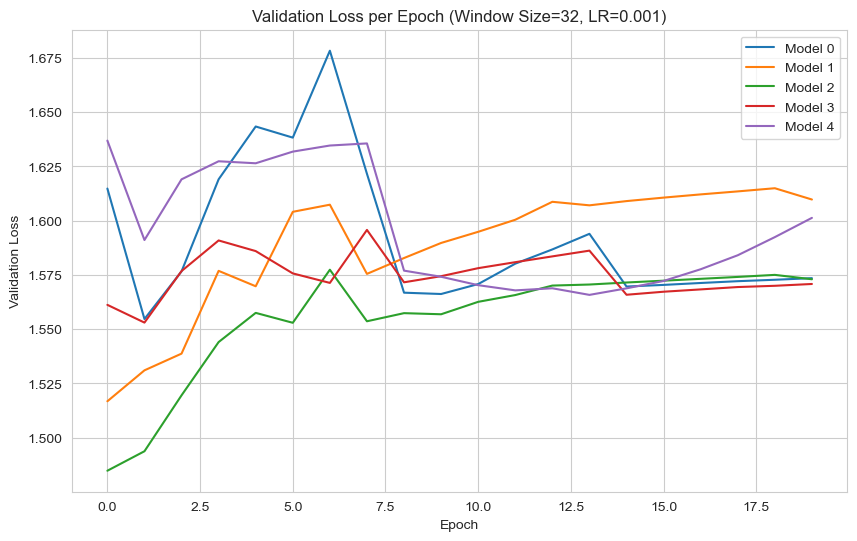

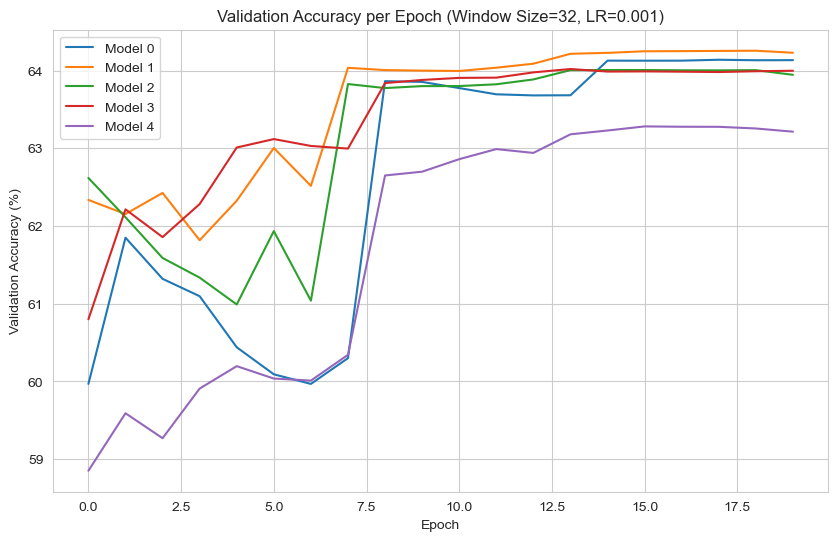

In [11]:
from torch.utils.data import Subset

# Hyperparameters
win_size = 32
num_models = 5
batch_size = 32
num_epochs = 20
learning_rate = 0.001
num_classes = 37

# fraction training set
fraction = 0.1

results = {}

for i in range(num_models):
    step_size = win_size // 2   # half overlapping windows

    # load datasets
    # Load full training dataset
    full_train_dataset = AudioChordDataset(csv_dir, train_csv_file_names, win_size, chord_to_int)
    # Get subset indices
    subset_size = int(fraction * len(full_train_dataset))
    subset_indices = np.random.choice(len(full_train_dataset), subset_size, replace=False)
    # Create subset dataset
    train_dataset = Subset(full_train_dataset, subset_indices)
    
    # class weight to make up for uneven dataset labels
    # Step 1: Compute class weights
    all_labels = [train_dataset[idx][1].item() for idx in range(len(train_dataset))]
    labels_counts = np.bincount(all_labels)  # Count occurrences for each label
    class_weights = 1.0 / (labels_counts + 1e-6)  # Avoid division by zero
    class_weights = torch.tensor(class_weights, dtype=torch.float32)  # Convert to tensor

    # # training dataloader with sampler applied
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    val_dataset = AudioChordDataset(csv_dir, val_csv_file_names, win_size, chord_to_int)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = AudioChordDataset(csv_dir, test_csv_file_names, win_size, chord_to_int)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # initialize model, loss function, optimizer
    model = CNN_Model(window_size=win_size, num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # record losses
    train_losses_cross_epoch = []
    val_losses_cross_epoch = []
    val_accuracy_cross_epoch = []

    # train loop
    for epoch in range(num_epochs):
        train_loss_per_epoch = []
        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for _, (win_chroma, win_label) in enumerate(train_dataloader):
                X = win_chroma.to(device)
                Y = win_label.to(device)
                
                # train
                optimizer.zero_grad()
                prediction = model(X)
                loss = criterion(prediction, Y)
                loss.backward()
                optimizer.step()

                # update progress bar
                pbar.set_postfix({"loss": loss.item()})     # display current loss
                pbar.update(1)      # advance progress bar by 1 batch

                # train loss per batch
                train_loss_per_epoch.append(loss.item())
            
        # calculate train loss for each epoch
        mean_train_loss_per_epoch = np.mean(train_loss_per_epoch)
        train_losses_cross_epoch.append(mean_train_loss_per_epoch)

        # evaluation
        model.eval()
        val_losses = []
        num_correct_per_epoch = 0
        num_total_per_epoch = 0
        with torch.no_grad():
            for _, (val_win_chroma, val_win_label) in enumerate(val_dataloader):
                val_X = val_win_chroma.to(device)
                val_Y = val_win_label.to(device)

                val_predictions = model(val_X)
                val_loss = criterion(val_predictions, val_Y).to('cpu')

                # val loss per batch
                val_losses.append(val_loss.item())

                # val accuracy per batch
                _, predicted_class = torch.max(val_predictions, 1)
                num_correct = (predicted_class == val_Y).sum().item()
                num_total_per_batch = val_Y.size(0)
                batch_accuracy = num_correct / num_total_per_batch

                # accumulate correct and total predictions from each batch
                num_correct_per_epoch += num_correct
                num_total_per_epoch += num_total_per_batch

        # calculate evaluation loss for each epoch
        mean_val_loss_per_epoch = np.mean(val_losses)
        mean_val_loss = np.mean(val_losses)
        val_losses_cross_epoch.append(mean_val_loss_per_epoch)

        # calculate accuracy per epoch
        val_accuracy = 100 * num_correct_per_epoch / num_total_per_epoch
        val_accuracy_cross_epoch.append(val_accuracy)

        # display loss & accuracy in progress bar
        print(f"val loss={mean_val_loss_per_epoch}; val accuracy={val_accuracy}%")
        
        # switch back to train mode
        model.train()
        
        # learning rate scheduler
        scheduler.step(mean_val_loss)
    
    print(i)
    # save loss and accuracy
    results[i] = {
        "train_losses": train_losses_cross_epoch,
        "val_losses": val_losses_cross_epoch,
        "val_accuracies": val_accuracy_cross_epoch
    }
    
print(results)

# 1. Training Loss
plt.figure(figsize=(10, 6))
for i in range(num_models):
    plt.plot(results[i]["train_losses"], label=f"Model {i}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f"Training Loss per Epoch (Window Size={win_size}, LR={learning_rate})")
plt.legend()
plt.show()

# 2. Validation Loss
plt.figure(figsize=(10, 6))
for i in range(num_models):
    plt.plot(results[i]["val_losses"], label=f"Model {i}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title(f"Validation Loss per Epoch (Window Size={win_size}, LR={learning_rate})")
plt.legend()
plt.show()

# 3. Validation Accuracy
plt.figure(figsize=(10, 6))
for i in range(num_models):
    plt.plot(results[i]["val_accuracies"], label=f"Model {i}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title(f"Validation Accuracy per Epoch (Window Size={win_size}, LR={learning_rate})")
plt.legend()
plt.show()
plt.show()